IMPORTAÇÕES

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

FUNÇÃO PARA PLOTAR O ESPECTRO DE FREQUÊNCIA


In [18]:
def plot_frequency_domain(image, title="Espectro de Frequência"):
    f = np.fft.fft2(image)
   
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  

    plt.figure(figsize=(6,6))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

CARREGAMENTO DE IMAGENS

In [19]:
imagem_complexa = cv2.imread('../images/imagem_complexa.png', 0)
ceu = cv2.imread('../images/ceu_limpo.jpg', 0)
xadrez = cv2.imread('../images/tecido_xadrez.jpg', 0)

In [20]:
def plot_frequency_domain(image, title="Espectro de Frequência"):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    plt.figure(figsize=(6,6))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

PLOTAGEM DAS IAMGENS CARREGADAS

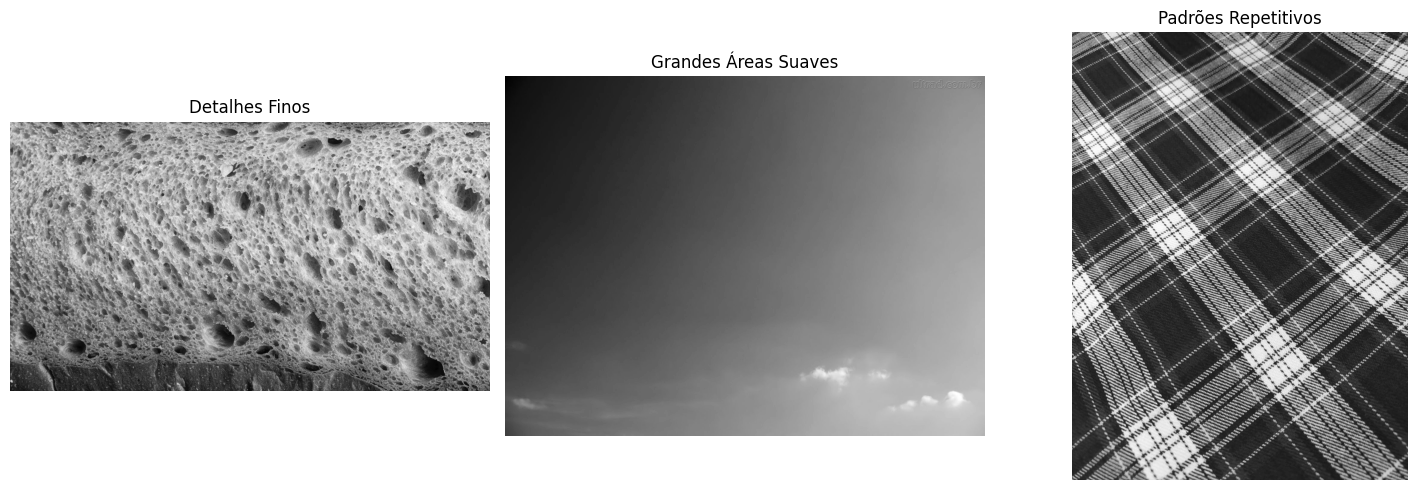

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(imagem_complexa, cmap='gray')
plt.title("Detalhes Finos")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(ceu, cmap='gray')
plt.title("Grandes Áreas Suaves")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(xadrez, cmap='gray')
plt.title("Padrões Repetitivos")
plt.axis('off')

plt.tight_layout()
plt.show()

FUNÇÃO PARA FILTRAGEM NO DOMÍNIO DA FREQUÊNCIA 

In [22]:
def filter_frequency_domain(image, filter_type="passband", **kwargs):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.float32)
    if filter_type == "passband":
        low_cut = kwargs.get("low_cut", 20)
        high_cut = kwargs.get("high_cut", 80)
        u = np.arange(rows)
        v = np.arange(cols)
        U, V = np.meshgrid(u, v, indexing='ij')
        D = np.sqrt((U - crow)**2 + (V - ccol)**2)
        mask = ((D >= low_cut) & (D <= high_cut)).astype(np.float32)
    elif filter_type == "directional":
        direction = kwargs.get("direction", "horizontal")
        band_width = kwargs.get("band_width", 10)
        if direction == "horizontal":
            mask[crow - band_width//2 : crow + band_width//2, :] = 0
        elif direction == "vertical":
            mask[:, ccol - band_width//2 : ccol + band_width//2] = 0
    fshift_filtered = fshift * mask
    magnitude_filtered = 20 * np.log(np.abs(fshift_filtered) + 1)
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)
    return img_filtered, magnitude_filtered

APLICAÇÃO DOS FILTROS

In [23]:
img = cv2.imread('../images/ceu_limpo.jpg', 0)
img_passband, mag_passband = filter_frequency_domain(img, filter_type="passband", low_cut=30, high_cut=80)
img_directional, mag_directional = filter_frequency_domain(img, filter_type="directional", direction="horizontal", band_width=10)

PLOTAGEM DOS RESULTADOS DOS FILTROS

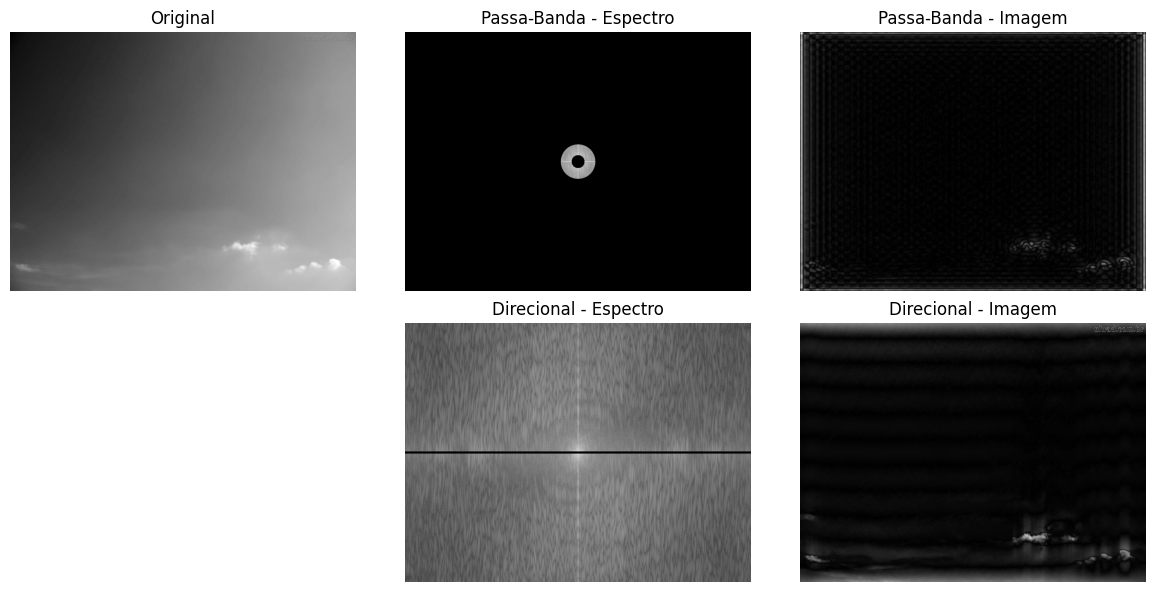

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(mag_passband, cmap='gray')
plt.title("Passa-Banda - Espectro")
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(img_passband, cmap='gray')
plt.title("Passa-Banda - Imagem")
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(mag_directional, cmap='gray')
plt.title("Direcional - Espectro")
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(img_directional, cmap='gray')
plt.title("Direcional - Imagem")
plt.axis('off')
plt.tight_layout()
plt.show()

REMOÇÃO DE RUÍDO PERIÓDICO

In [25]:
image_path = '../images/ceu_limpo.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [26]:
if image is None:
    print("Erro ao carregar a imagem. Verifique o caminho do arquivo.")
else: # Adiciona ruídos periódicos na imagem
    rows, cols = image.shape
    for i in range(0, rows, 10):
        image[i:i+2, :] = 255

APLICAR A TRANSFORMADA DE FOURIER

In [27]:

dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

MODIFICAR O ESPECTRO DE MAGNITUDE PARA REMOVER O RUÍDO

In [28]:
crow, ccol = rows // 2, cols // 2
mask = np.ones((rows, cols, 2), np.uint8)
mask[crow-5:crow+5, ccol-30:ccol+30] = 0
fshift = dft_shift * mask

RECONSTRUIR A IMAGEM USANDO A TRANSFORMADA INVERSA DE FOURIER

In [29]:
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

COMPARAR OS RESULTADOS ANTES E DEPOIS DA FILTRAGEM

C:\Users\joaov\AppData\Local\Temp\ipykernel_12320\266522589.py:14: RuntimeWarning: divide by zero encountered in log
  plt.imshow(20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1])), cmap='gray')


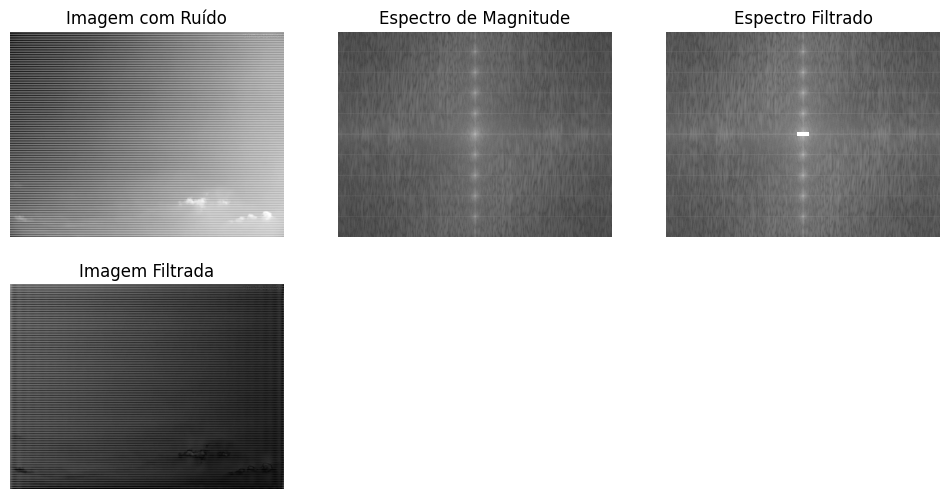

Observações:
1. A imagem original contém listras horizontais devido ao ruído periódico adicionado.
2. O espectro de magnitude mostra componentes de alta energia associados ao ruído.
3. Após a filtragem, os componentes de alta energia são removidos do espectro.
4. A imagem reconstruída mostra uma redução significativa do ruído periódico.


In [30]:
plt.figure(figsize=(12, 6))
    
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem com Ruído')
plt.axis('off')
    
plt.subplot(2, 3, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Espectro de Magnitude')
plt.axis('off')
    
plt.subplot(2, 3, 3)
plt.imshow(20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1])), cmap='gray')
plt.title('Espectro Filtrado')
plt.axis('off')
    
plt.subplot(2, 3, 4)
plt.imshow(img_back, cmap='gray')
plt.title('Imagem Filtrada')
plt.axis('off')
    
plt.show()

print("Observações:")
print("1. A imagem original contém listras horizontais devido ao ruído periódico adicionado.")
print("2. O espectro de magnitude mostra componentes de alta energia associados ao ruído.")
print("3. Após a filtragem, os componentes de alta energia são removidos do espectro.")
print("4. A imagem reconstruída mostra uma redução significativa do ruído periódico.")